# Genetic Algorithm
Written by Scott Condron<br>
Created: July 22, 2020<br>
October 29, 2020

In [ ]:
import math
import numpy as np
import pandas as pd
import random
from holoviews import opts
import holoviews as hv
import panel as pn
from holoviews.streams import Stream
hv.extension('bokeh', logo=False)

# What are we doing?

How can you maximise the number of components in a laptop, while having size, weight and price constraints? For questions like these, we often want to reach for optimisation algorithms, and one particularly fun one is Genetic Algorithm. 

# Our example problem

For the sake of a fun visualisation, let's say the optimisation is "Wherever I click on the plot is the *optimimum* spot to find". We're going to use a population-based approach, Genetic Algorithm, in which there is a population of individuals (each individual representing a possible solution) which evolve across generations. 

# What we want to see

We want to see a kind of "evolution simulator" in which we click a spot on the plot and when we begin evolving, each generation moves closer to the place we clicked.

# We need a population

"And God said, Let us make man in our image". First, let's create a population.

In [ ]:
def create_population(population_size, vector_length):
    return np.random.rand(population_size, vector_length)

In [ ]:
population_size = 100
vector_length = 2
current_population = create_population(population_size, vector_length)
hv.Scatter(current_population)

# Survival of the fittest

We're going to need to *evolve* individuals from our population, so we need some way to check which of the population is the fittest. 

### Closer (smaller distance) is better

For the sake of this visualisation, we're going to place a target on the plot and the "fitness" of a individual is how close they are to the target. We're going to calculate the distance using the euclidean distance metric.



In [ ]:
def mean_squared_error(y_true, y_pred):
    return ((y_true - y_pred)**2).mean(axis=0)

target_x, target_y = 0,0  
def problem(soln):
    global target_x #using globals so we can link this to the click event later
    global target_y
    return mean_squared_error(soln, [target_x, target_y])

Then we need a way to check, who's our fittest member of our community

In [ ]:
def assess_fitness(individual, problem):
    "Determines the fitness of an individual using the given problem"
    return problem(individual)

def find_current_best(population, problem):
    """Evaluates a given population and returns the fittest individual.
    This can be sped up to only loop over popuation once, but because this is a tutorial, 3 lines is nicer.
    """
    fitnesses = [assess_fitness(x, problem) for x in population]
    best_value = min(fitnesses) # Lowest is best
    best_index = fitnesses.index(best_value)
    return population[best_index]

## aaaand Fight!

Now, we're going to let these potential solutions fight it out and only let a certain few have offspring. For this we will use "Tournament Selection" which is just grabbing a few individuals and having them compete to the death (the fittest survives!). 

What's nice about this is that you can keep a bit of diversity within the population and it's not just **the best** that survive, some lucky unfit individuals might be matched up with worse folk, and so they'll survive.

In [ ]:
def tournament_select_with_replacement(population, tournament_size, problem):
    "Competes a number of challengers and returns the fittest one"
    challengers_indexes = np.random.choice(population.shape[0], tournament_size, replace=True)
    challengers = population[challengers_indexes]
    return find_current_best(challengers, problem)

Then once we have done this twice, those two individuals can "mate" and have children... to keep the population the same across generations for simplicity, they'll have two children. We'll use [Two point Crossover](https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)), which is just splitting both parents in three parts and swapping the middle part to form two children.

In [ ]:
def crossover(parent_a, parent_b):
    "Performs two point crossover on two parents"
    l = parent_a.shape[0]
    c, d = random.randint(0, l), random.randint(0, l)
    
    # Flip if c greater than d
    if (c > d): d, c = c, d 
    if (c == d): d += 1
    temp = np.copy(parent_a)
    child_a = np.concatenate([parent_a[0:c], parent_b[c:d], parent_a[d:]])
    child_b = np.concatenate([parent_b[0:c], temp[c:d], parent_b[d:]]) 
    return child_a, child_b

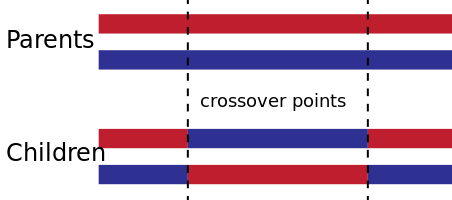 Source: Wikipedia

# Mutate!

For extra variety across generations, we want to introduce a bit of chaos to the system to produce the Marie Curie of each generation (but also probably our _least_ capable individuals too). This helps find _new_ solutions outside our current population's capability. So for each individual, there's a chance that their offspring will mutate (determined by `mutation_rate`).

In [ ]:
def mutate(child, mutation_rate, mutation_scale):
    "May mutate a child using Gaussian convolution"
    if mutation_rate >= random.uniform(0, 1):
        size = child.shape[0]
        mutation_value = np.random.normal(0, mutation_scale, size)
        child = child + mutation_value
    return child

Here's the entirety of what happens to the population between generations. 
To recap: a bunch from the current population are selected at random to compete to reproduce. Two parents then produce two children using a mix of the two parents for both children. Finally, each child has a chance that they will mutate. One we've created a new population of the same size as the original population, we have completed one "generation".

In [ ]:
def update_population(current_population, problem, should_mutate, mutation_rate, mutation_scale):
    """Performs one generational update of Genetic Algorithm"""
    pop_size = len(current_population)
    next_population = np.empty((pop_size, 2))
    tournament_size=2
    for i in range(int(pop_size / 2)):
#         breakpoint()
        parent_a = tournament_select_with_replacement(current_population, tournament_size, problem)
        parent_b = tournament_select_with_replacement(current_population, tournament_size, problem)
        child_a, child_b = crossover(parent_a, parent_b)
        next_population[i] = mutate(child_a, mutation_rate, mutation_scale) if should_mutate else child_a 
        position_child_b = i + (pop_size / 2)
        next_population[int(position_child_b)] = mutate(child_b, mutation_rate, mutation_scale) if should_mutate else child_b
    return next_population

# A little class for saving the state of the evolution 

In [ ]:
class GeneticAlgorithm(object):
    def __init__(self, population_size, vector_length, problem):
        self.problem = problem
        self.current_population = create_population(population_size, vector_length)
        self.current_best = find_current_best(self.current_population, self.problem)
    
    def next_generation(self, mrate, mscale, should_mutate):
        self.current_population = update_population(self.current_population, self.problem, should_mutate, mrate, mscale)
        self.current_best = find_current_best(self.current_population, self.problem)

ga = GeneticAlgorithm(population_size, vector_length, problem)

# Interact

The sliders, tap streams, and buttons for our dashboard. `run_button` begins a periodic update of our evolution process when clicked. `next_generation_button` triggers just one generational update. `new_pop_button` triggers the creation of a new population. The rest are just sliders and markdown for the other bits and bobs. This is then positioned out using `pn.Column`, `pn.Row` and `pn.Spacer` from `panel`.

In [ ]:
def tap_event(x,y):
    global target_x
    global target_y
    if x is not None:
        target_x, target_y = x,y
    return hv.Points((x,y,1))

target_x, target_y = 10, -10
tap = hv.streams.SingleTap(transient=True, x=target_x, y=target_y)
tap_dmap = hv.DynamicMap(tap_event, streams=[tap]).opts(color='r', marker='^', size=10)
mutate_checkbox = pn.widgets.Checkbox(name='Mutate', value=True)
niters_slider = pn.widgets.IntSlider(name='Time Evolving (s)', start=0, end=50, value=5)
mutation_rate_slider = pn.widgets.FloatSlider(name='Mutation Rate', start=0.0, end=1.0, value=0.3)
mutation_scale_slider = pn.widgets.IntSlider(name='Mutation Scale', start=0, end=50, value=1)

new_pop_button = pn.widgets.Button(name='New Population', width=50)
def e(event):  
    population_size = 100
    vector_length = 2
    global ga
    ga = GeneticAlgorithm(population_size, vector_length, problem)
    hv.streams.Stream.trigger(dmap.streams)
new_pop_button.on_click(e)

next_generation_button = pn.widgets.Button(name='Next Generation', width=50)
def next_gen_event(event):
    hv.streams.Stream.trigger(dmap.streams)
next_generation_button.on_click(next_gen_event)

def update():
    ga.next_generation(mutation_rate_slider.value, mutation_scale_slider.value, mutate_checkbox.value)
    return hv.Scatter(ga.current_population, label='Population').opts(color='b')*hv.Points((ga.current_best[0], ga.current_best[1],1), label='Current Fittest').opts(color='c', size=10)
dmap = hv.DynamicMap(update, streams=[Stream.define('Next')()])

run_button = pn.widgets.Button(name='\u25b6 Begin Evolving', width=50)
def b(event):    
    dmap.periodic(0.1, timeout=niters_slider.value, block=False) # Run the simulation for 60 seconds    
run_button.on_click(b)

instructions = pn.pane.Markdown('''
# Genetic Algorithm Dashboard 
## Instructions: 
1. **Click on the plot to place the target.** 
2. Click '\u25b6 Begin Evolution' button to begin evolving for the time on the Time Evolving slider. 
3. Experiment with the Mutation Rate (the probability of an individual in the next generation mutating) 
4. Experiment with the Mutation Scale (the size of the mutation, tip: zoom out using the Wheel Zoom on the right of the plot). 
''')
dashboard = pn.Column(instructions, pn.Row((dmap*tap_dmap.relabel('Target')).opts(width=600, height=600), 
                             pn.Column(pn.Row(run_button, pn.Spacer(width=50), new_pop_button), next_generation_button,
                             mutate_checkbox, niters_slider, mutation_rate_slider, mutation_scale_slider)))

In [ ]:
dashboard

In [ ]:
# server = pn.serve(dashboard, start=False, show=False)

In [ ]:
dashboard.servable()